In [11]:
import numpy as np
import cv2 as cv
from cake import cake
from matplotlib import pyplot as plt
import matplotlib.colors
from scipy import signal
from scipy.spatial.transform import Rotation as R
from cluster_half_shelfs_alpha import Half_shelf_cluster
from cluster_to_edge_pixel import contour_edge
from confectionery import Confectionery
from utitlity_functions import *
from scipy.spatial.transform import Rotation as R
import matplotlib as mpl
from matplotlib import cm
from particle_data_structure import ParticleDataStruct
import os

# input parameter

In [12]:
folder_name="Gute_aufnahme_shortened"
vizualised_obj_id=15


In [13]:
data_paths=os.listdir(os.path.join("data",folder_name))
stream_string=np.load(os.path.join("data",folder_name,"image_paths_smooth.npy"))
objs=[x for x in data_paths if "pos_data" in x]
objs_number=np.array([int(x[9:-4]) for x in objs])
indexing=np.argsort(objs_number)
objs=[np.load(os.path.join("data",folder_name,objs[x])) for x in indexing]
number_objs=len(objs)

koppenrath=Confectionery()

destination_normal_vector_traj=os.path.join("data",folder_name,"normal_vector_trajectory_")
destination_rotation_traj_as_rotvec=os.path.join("data",folder_name,"rotation_trajectory_as_rotvec_")

particle_structured3d_path=os.path.join("data",folder_name,"particle_structured3d_")
particle_structured_flat_path=os.path.join("data",folder_name,"particle_structured_flat_")

In [14]:
cut_radius=[int(np.floor(np.mean(x[:,-1])))-1 for x in objs]
structured_datas=[ParticleDataStruct(x,stream_string,c,koppenrath) for x,c in zip(objs,cut_radius)]
particle_datas_3d=[np.load(particle_structured3d_path+str(i)+".npy")for i in range(number_objs)]
particle_datas_flat=[np.load(particle_structured_flat_path+str(i)+".npy") for i in range(number_objs)]
particle_datas_flat_effective=[x.get_data_flatten_effective(c,y) for x,y,c in zip(structured_datas,particle_datas_flat,cut_radius)]

In [15]:
half_shelf_clusters=[Half_shelf_cluster(objs, stream_string, confectionery=koppenrath,cut_radius=c) for x,c in zip(objs,cut_radius)]
for i in range(number_objs):
    half_shelf_clusters[i].load_data_from_np_array(particle_datas_flat_effective[i].flatten())

In [16]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Clustering

In [ ]:
objects_clustered=[]
for i in range(number_objs):
    label=half_shelf_clusters[i].label(particle_datas_flat_effective[i].flatten(),method="GMM")
    label=label+1
    label_flat_effective=label.reshape(particle_datas_flat_effective[i].shape)
    label_flat=structured_datas[i].data_flatten_effective_to_data_flat(cut_radius[i],label_flat_effective)
    objects_clustered.append(structured_datas[i].expand_data(label_flat))


# Compute Edges

In [ ]:
edge_pixels_locals=[]
for i in range(number_objs):
    edge_pixels_local_trajectory=[]
    edge_object=contour_edge(objects_clustered[i], cut_radius=cut_radius[i], confectionery=koppenrath)
    edge_object.compute_edges()
    edge_object.reduce_edges()
    edge_pixels=edge_object.edge_pixels
    radius=round(np.mean(objs[i][:,-1]))
    center=np.array([radius,radius]).reshape((1,2))
    for i in range(particle_datas_3d[i].shape[0]):
        edge_pixels_local=edge_pixels[i][:,:-1]-center
        z=-np.sqrt(radius**2-np.sum(edge_pixels_local**2,axis=1).reshape((-1,1)))
        edge_pixels_3d_local=np.concatenate((edge_pixels_local,z),axis=1)
        edge_pixels_local_trajectory.append(edge_pixels_3d_local)
    edge_pixels_locals.append(edge_pixels_local_trajectory)

# Calculate Normal Vectors and Rotation Trajectories

In [ ]:
normal_vector_trajectories=[]
rotation_trajectories_as_rotvec=[]

for j in range(number_objs):
    normal_vector_trajectory=np.zeros((3,len(edge_pixels_locals[j])))
    if edge_pixels_locals[j][0].size==0:
        n=normal_vector_degenerate(objects_clustered[j][0,:,:])
    else:
        n=caluclate_normal_vector_from_contour(edge_pixels_locals[j][0])
        n=orient_normal_plane(n, objects_clustered[j][0,:,:], objs[j], 0)
    normal_vector_trajectory[:,0]=n

    
    for i in range(1,len(edge_pixels_locals[j])):
        if edge_pixels_locals[j][i].size==0:
            n=normal_vector_degenerate(objects_clustered[j][i,:,:])
        else:
            n=caluclate_normal_vector_from_contour(edge_pixels_locals[j][i])
            n=orient_normal_plane(n, objects_clustered[j][i,:,:], objs[j], i)
        normal_vector_trajectory[:,i]=n
    rotation_trajectory=calculate_rotations_from_normal_vector_trajectory(normal_vector_trajectory)
    rotation_trajectory_as_rotvec=np.array([r.as_rotvec() for r in rotation_trajectory.values()])

    normal_vector_trajectories.append(normal_vector_trajectory)
    rotation_trajectories_as_rotvec.append(rotation_trajectory_as_rotvec)




# Save numpy arrays

In [ ]:
for i in range(number_objs):
    np.save(destination_normal_vector_traj+str(i)+".npy",normal_vector_trajectories[i])
    np.save(destination_rotation_traj_as_rotvec+str(i)+".npy",rotation_trajectories_as_rotvec[i])


# Visualizations

In [ ]:
i=vizualised_obj_id
half_shelf_cluster=half_shelf_clusters[i]
particle_data_flat_effective=particle_datas_flat_effective[i]
particle_data_3d=particle_datas_3d[i]
structured_data=structured_datas[i]
object_trajectory=objs[i]
frame_number=int(object_trajectory[0,0])

In [ ]:
# cluster
label=half_shelf_cluster.label(particle_data_flat_effective.flatten(),method="GMM")
label=label+1
label_flat_effective=label.reshape(particle_data_flat_effective.shape)
label_flat=structured_data.data_flatten_effective_to_data_flat(cut_radius[i],label_flat_effective)
objects_clustered=structured_data.expand_data(label_flat)


In [ ]:
edge_object=contour_edge(objects_clustered, cut_radius=cut_radius[i], confectionery=koppenrath)
edge_object.compute_edges()
edge_matrix=edge_object.edge_matrix[0,:,:]
edge_pixels=edge_object.edge_pixels[0]
a_pixel=edge_pixels[edge_pixels[:,-1]==0,:]
b_pixel=edge_pixels[edge_pixels[:,-1]==1,:]
fig,ax=plt.subplots(1,3)
fig.set_figheight(8)
fig.set_figwidth(18)
ax[0].imshow(objects_clustered[0,:,:])
ax[0].scatter(a_pixel[:,0],a_pixel[:,1],color = 'hotpink')
ax[0].scatter(b_pixel[:,0],b_pixel[:,1],color = 'brown')
ax[1].imshow(objects_clustered[0,:,:])
img_test=np.load(stream_string[frame_number])
obj_test=objs[i]
x_center=round(obj_test[0,1])
y_center=round(obj_test[0,2])
r=cut_radius[i]
obj_im_test=cv.cvtColor(img_test[y_center-r:y_center+r+1,x_center-r:x_center+r+1,:],cv.COLOR_BGR2GRAY)
M=koppenrath.sell_cake(r,2*r+1,2*r+1)
vmin=np.min(obj_im_test[M==1])
vmax=np.max(obj_im_test[M==1])
ax[2].imshow(obj_im_test,cmap="gray",vmin=vmin,vmax=vmax)
fig.tight_layout()
plt.show()



In [ ]:
edge_object.reduce_edges()
edge_pixels=edge_object.edge_pixels
plt.imshow(objects_clustered[0,:,:])
plt.scatter(edge_pixels[0][:,0],edge_pixels[0][:,1],color = 'hotpink')
plt.show()


In [ ]:
A=[]
B=[]
C=[]
for i in range(np.min([110,objects_clustered.shape[0]])):
    # get ROI


    plt.figure()
    ax=plt.subplot(121)
    ax.set_title(str(i))
    ax.imshow(objects_clustered[i,:,:],vmin=0, vmax=2)
    plt.scatter(edge_pixels[i][:,0],edge_pixels[i][:,1],color = 'hotpink')
    ax=plt.subplot(122)
    obj_im_plot=particle_data_3d[i,:,:]
    vmin=np.min(obj_im_plot[M==1])
    vmax=np.max(obj_im_plot[M==1])
    ax.imshow(obj_im_plot,cmap="gray",vmin=vmin, vmax=vmax)
    A.append(objects_clustered[i,:,:])
    B.append(particle_data_3d[i,:,:])
    C.append(edge_pixels[i])
    plt.show()



# Save all edge pixels in array

In [ ]:
radius=round(np.mean(object_trajectory[:,-1]))
center=np.array([radius,radius]).reshape((1,2))
edge_pixels_local_trajectory=[]
for i in range(particle_data_3d.shape[0]):
    edge_pixels_local=edge_pixels[i][:,:-1]-center
    z=-np.sqrt(radius**2-np.sum(edge_pixels_local**2,axis=1).reshape((-1,1)))
    edge_pixels_3d_local=np.concatenate((edge_pixels_local,z),axis=1)
    edge_pixels_local_trajectory.append(edge_pixels_3d_local)
    
    

# Calculate normal vectors from edge pixels local 3d trajectory

In [ ]:
normal_vector_trajectory=np.zeros((3,len(edge_pixels_local_trajectory)))
if edge_pixels_local_trajectory[0].size==0:
    n=normal_vector_degenerate(objects_clustered[0])
else:
    n=caluclate_normal_vector_from_contour(edge_pixels_local_trajectory[0])
    n=orient_normal_plane(n, objects_clustered[0], object_trajectory, 0)
normal_vector_trajectory[:,0]=n
for i in range(1,len(edge_pixels_local_trajectory)):
    if edge_pixels_local_trajectory[i].size==0:
        n=normal_vector_degenerate(objects_clustered[i])
    else:
        n=caluclate_normal_vector_from_contour(edge_pixels_local_trajectory[i])
        n=orient_normal_plane(n, objects_clustered[i], object_trajectory, i)
    normal_vector_trajectory[:,i]=n



# draw 2d projections of normal vector

In [ ]:
width=A[0].shape[0]
arrow_length = width//2
start_point = (width // 2, width // 2)


cmap = matplotlib.colors.ListedColormap(
                                        [[68,1,84],
                                         [100,145,140],
                                         [253,231,37],
                                         [0,255,255]
                                         ])
for i in range(len(A)):
    v=np.copy(normal_vector_trajectory[:,i])
    v=v[:2]
    if np.linalg.norm(v)>1e-6:
        v/=np.linalg.norm(v)
    end_point = (start_point[0] + int(v[0] * arrow_length), start_point[1] + int(v[1] * arrow_length))
    im_obj=np.zeros((A[i].shape[0],A[i].shape[1],3),dtype=np.uint8)
    im_obj=cv.arrowedLine(im_obj, start_point, end_point, (0,0,255), 1)
    im_obj=cv.cvtColor(im_obj, cv.COLOR_BGR2GRAY)
    arrow_pixels=np.argwhere(im_obj==np.max(im_obj))
    im_obj=np.copy(A[i])
    im_obj[arrow_pixels[:,0],arrow_pixels[:,1]]=3
    fig = plt.figure()
    ax1 = fig.add_subplot(121)    
    ax1.set_title(str(i))
    a=ax1.imshow(im_obj, cmap=cmap,vmin=0,vmax=3)
    ax1.scatter(C[i][:,0],C[i][:,1],color = 'hotpink')
    fig.colorbar(a,orientation='horizontal')
    ax=plt.subplot(122)
    obj_im_plot=particle_data_3d[i,:,:]
    vmin=np.min(obj_im_plot[M==1])
    vmax=np.max(obj_im_plot[M==1])
    ax.imshow(B[i],cmap="gray",vmin=vmin,vmax=vmax)
    plt.show()


# draw 2d projections of normal vector and rotvec

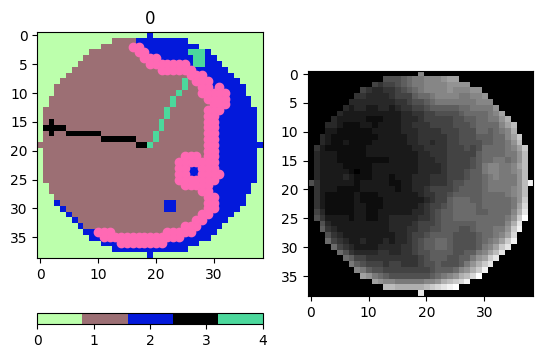

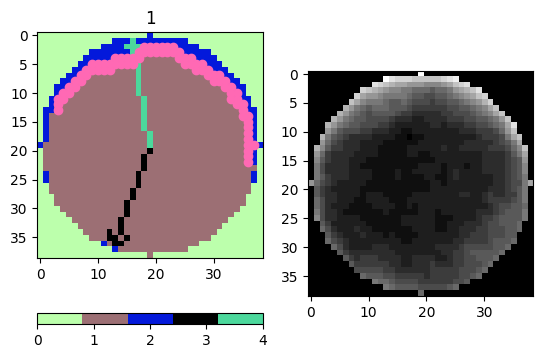

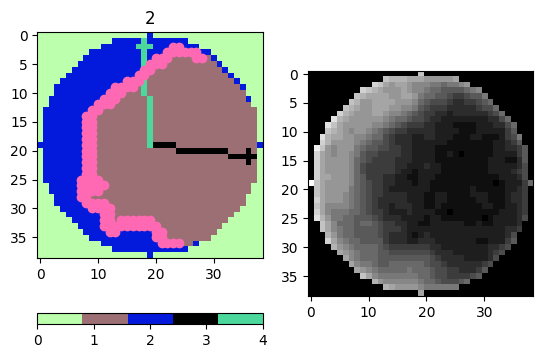

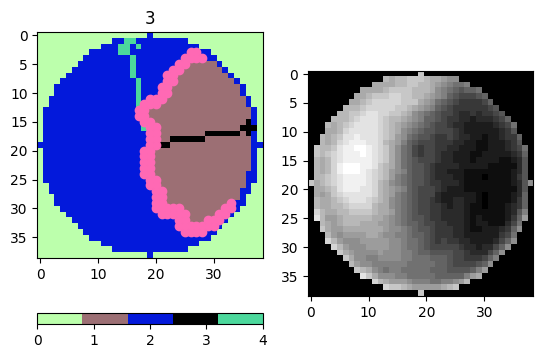

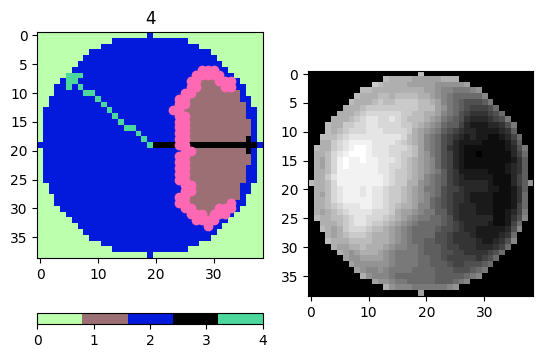

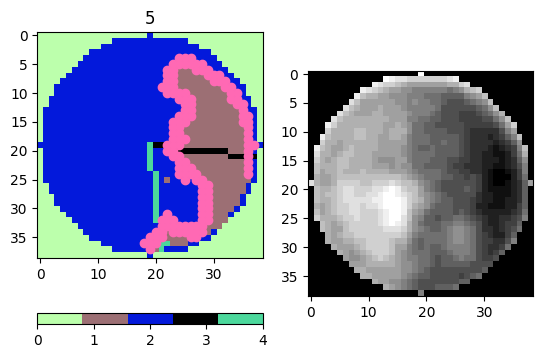

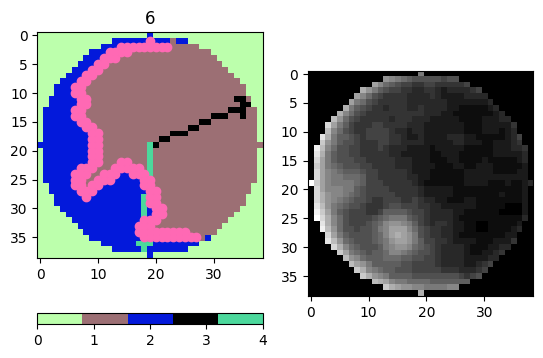

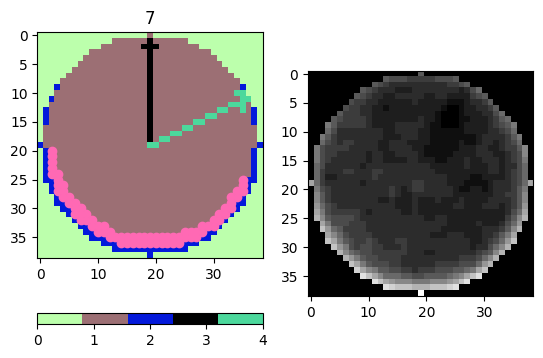

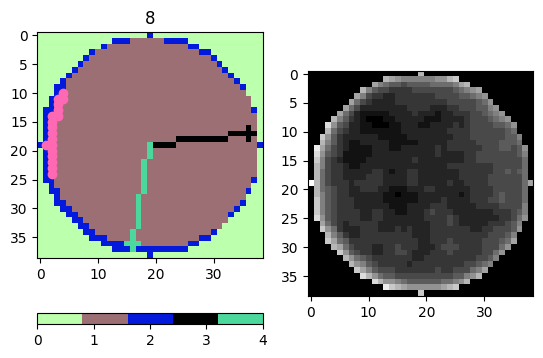

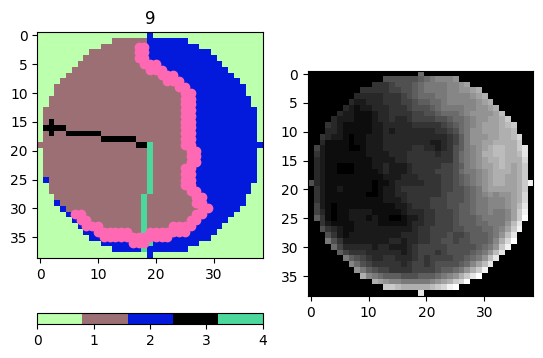

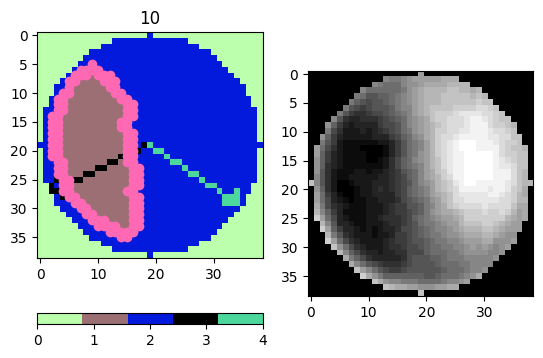

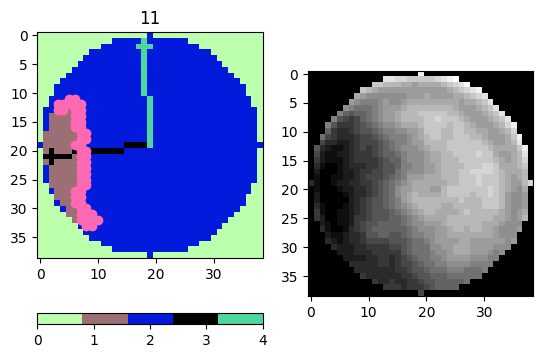

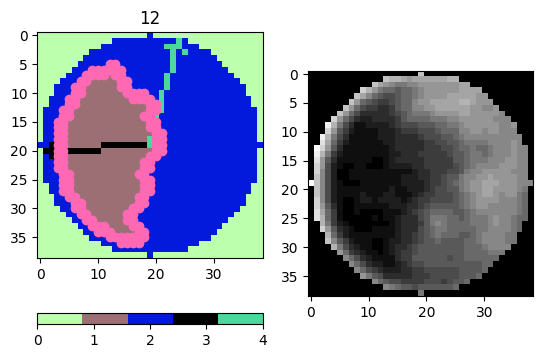

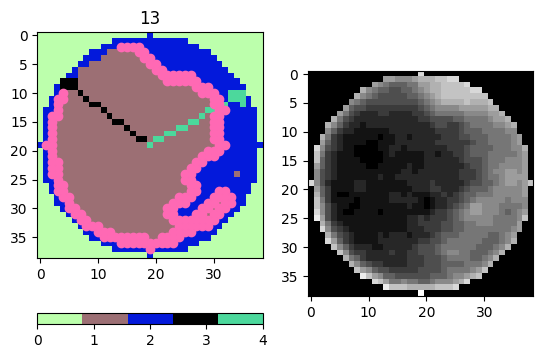

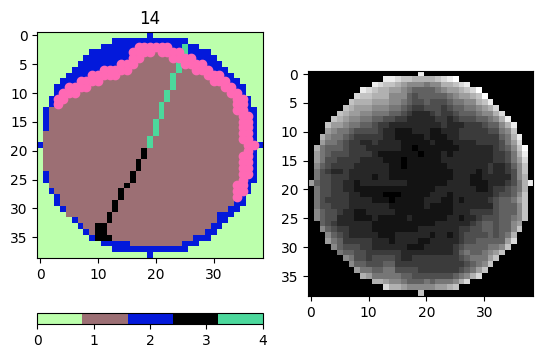

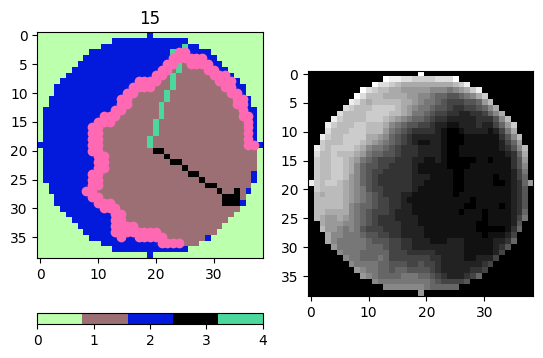

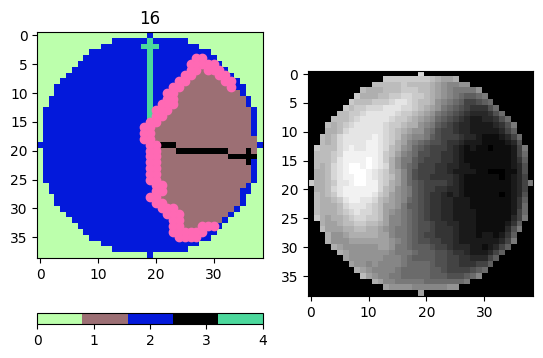

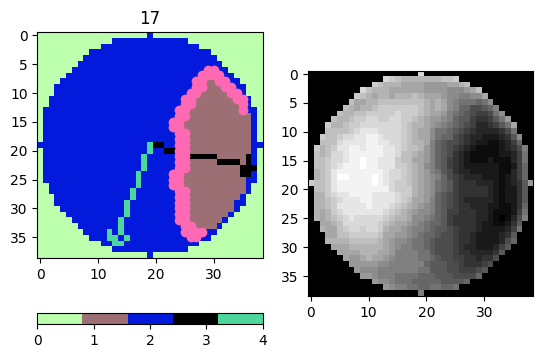

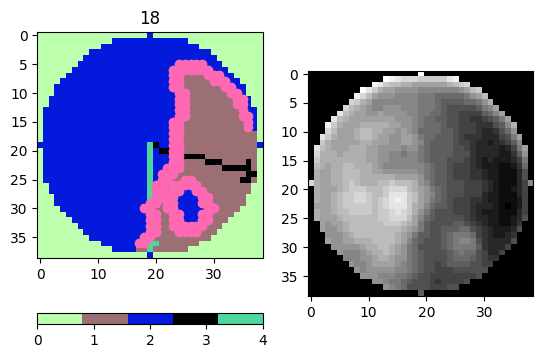

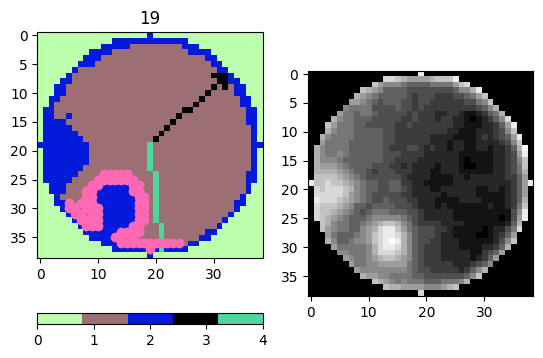

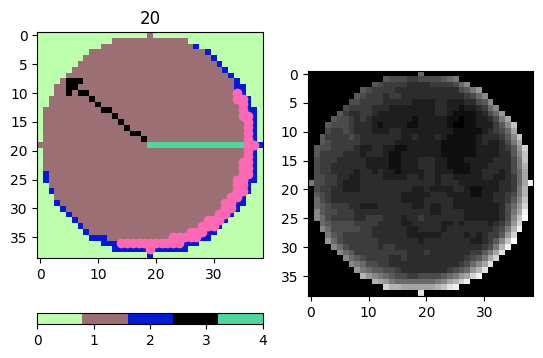

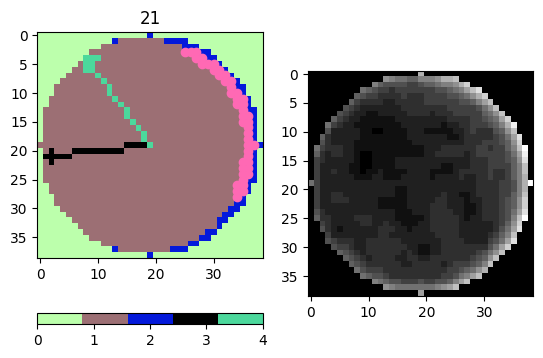

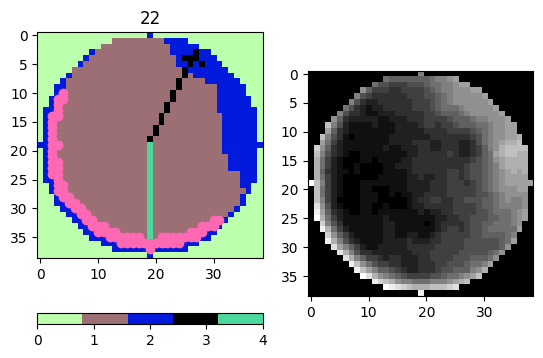

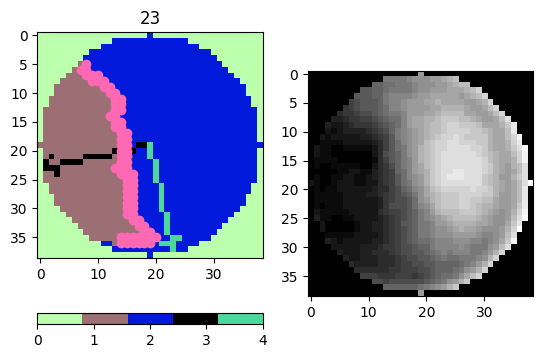

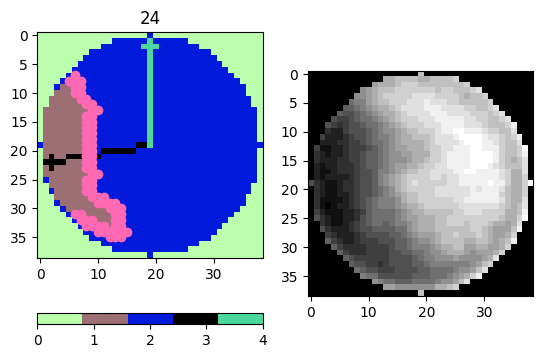

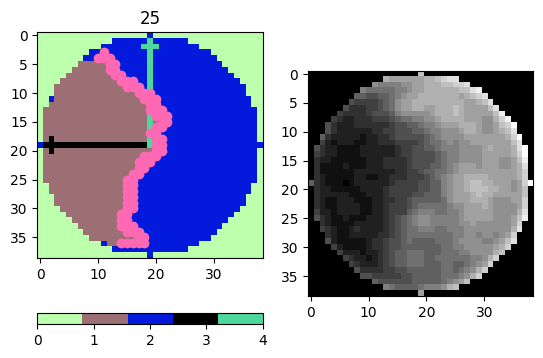

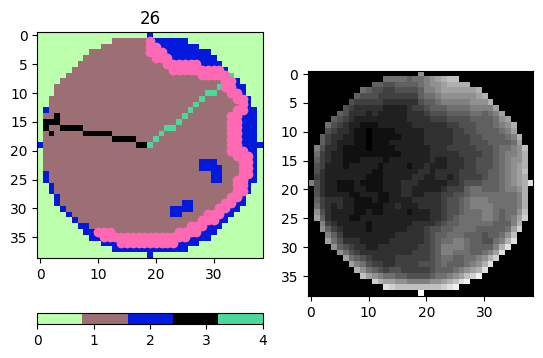

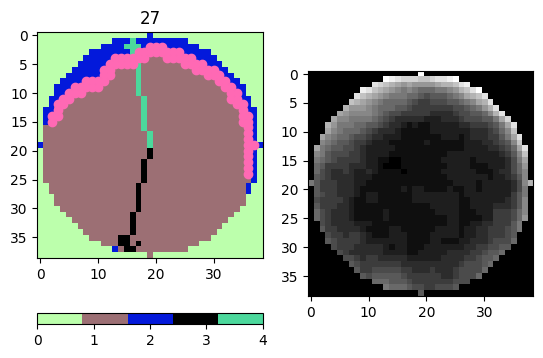

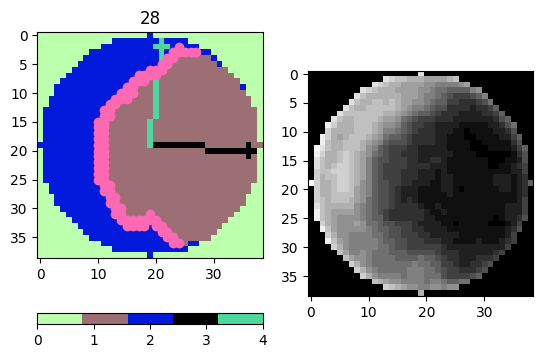

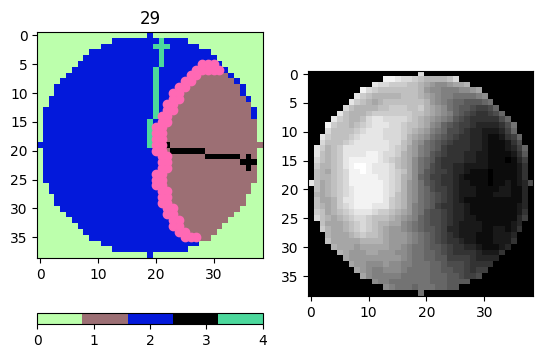

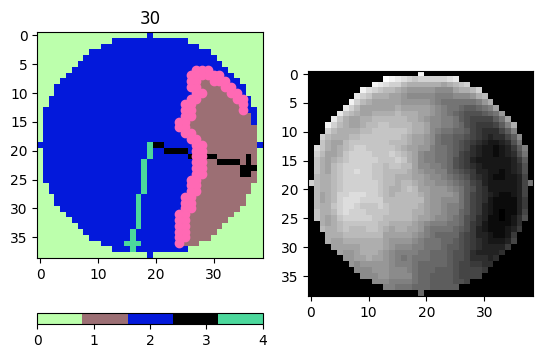

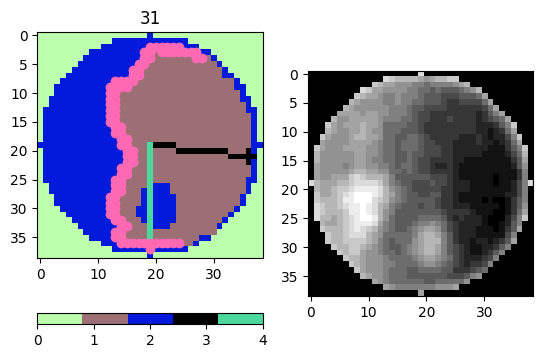

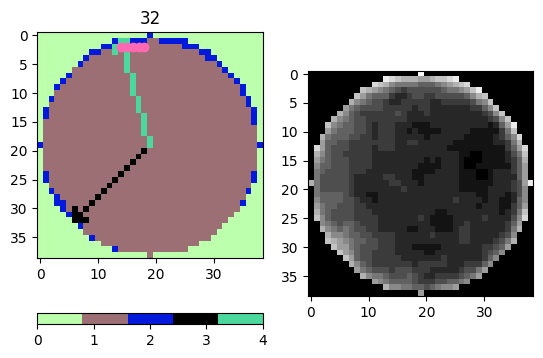

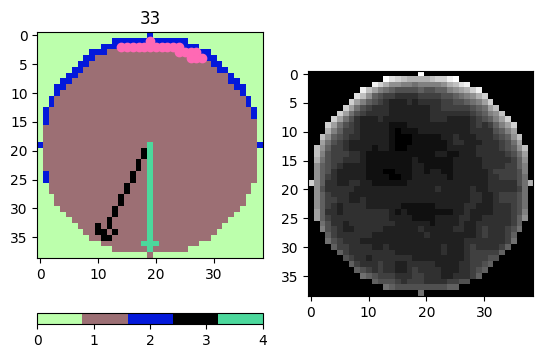

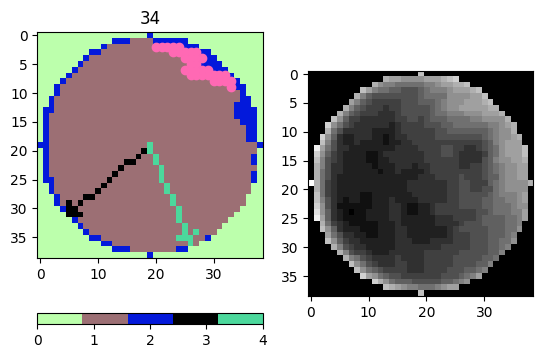

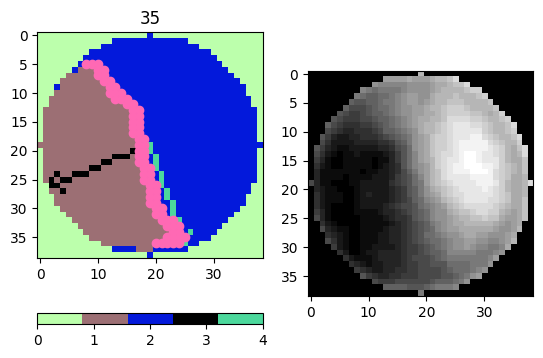

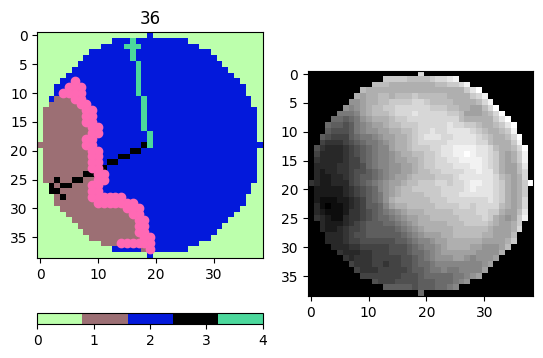

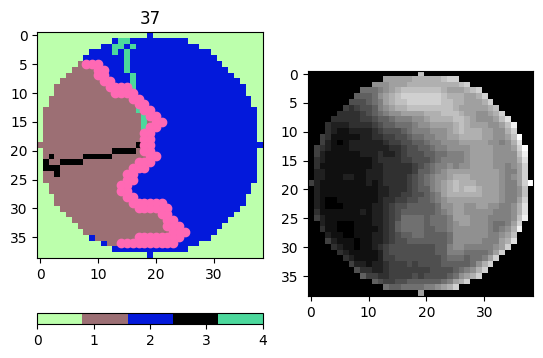

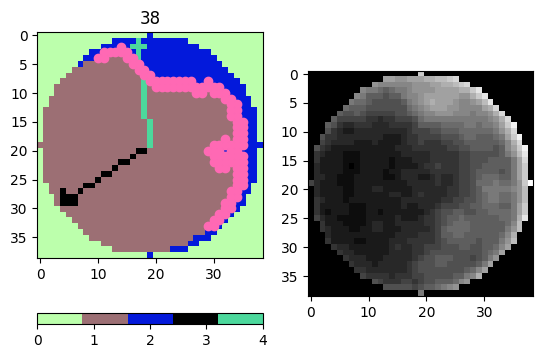

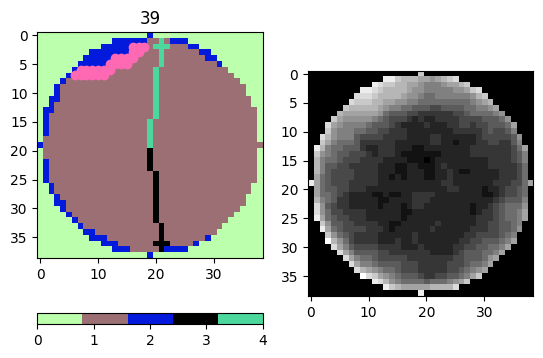

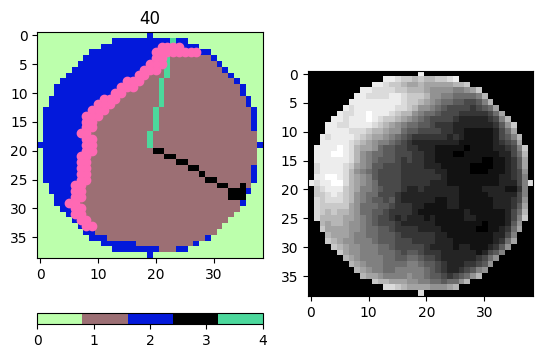

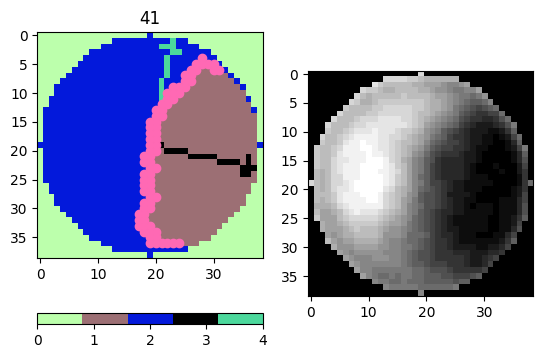

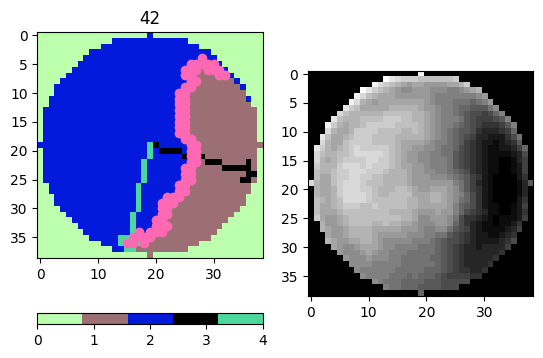

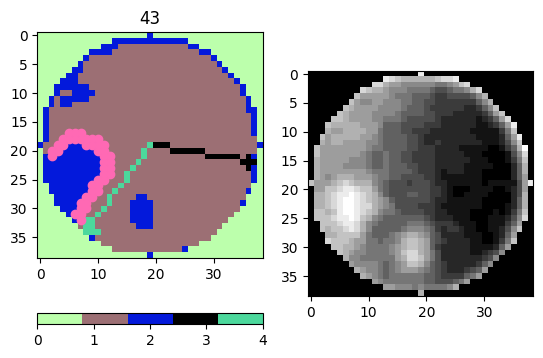

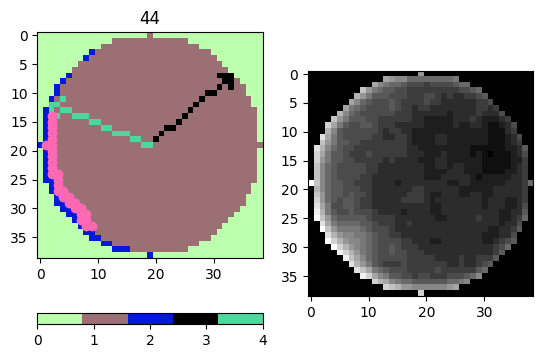

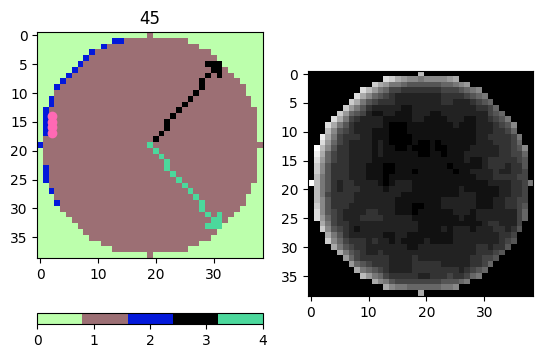

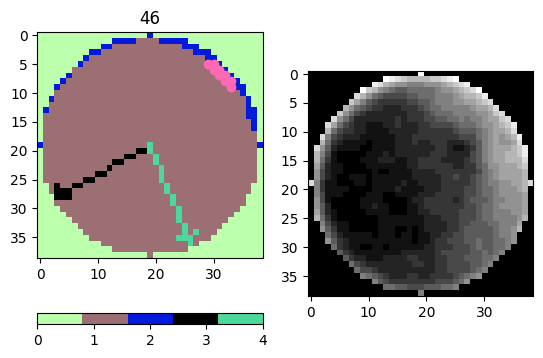

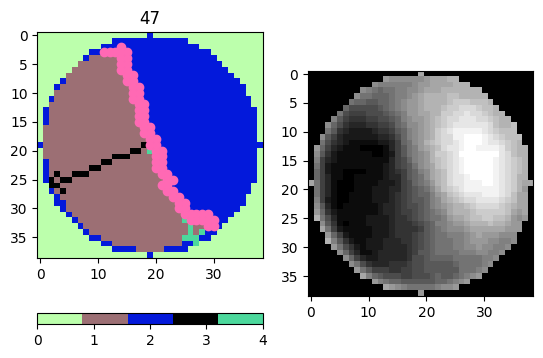

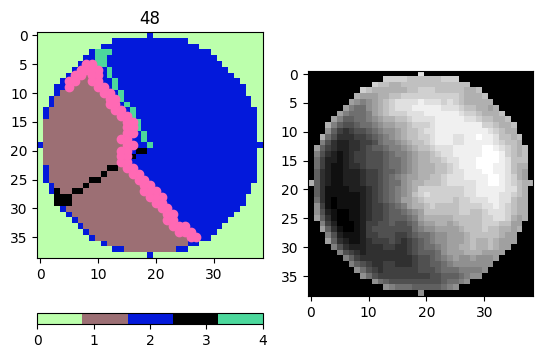

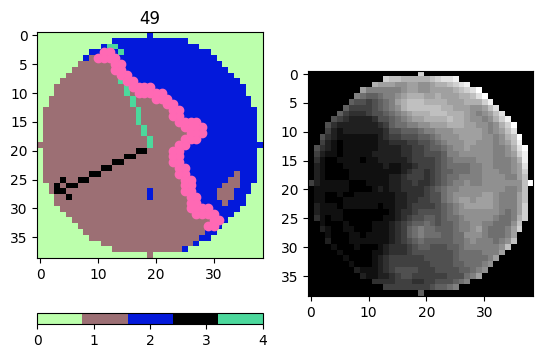

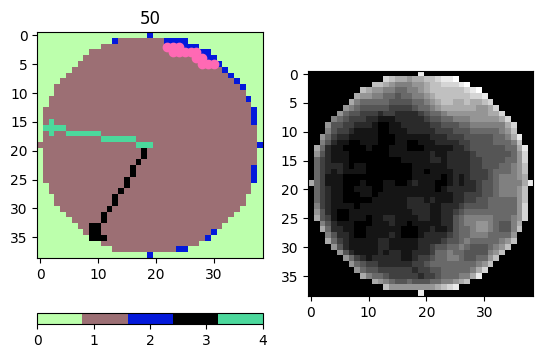

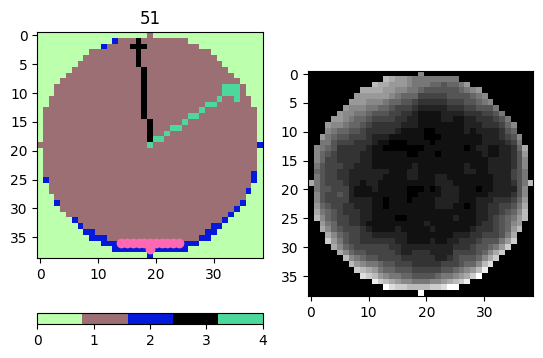

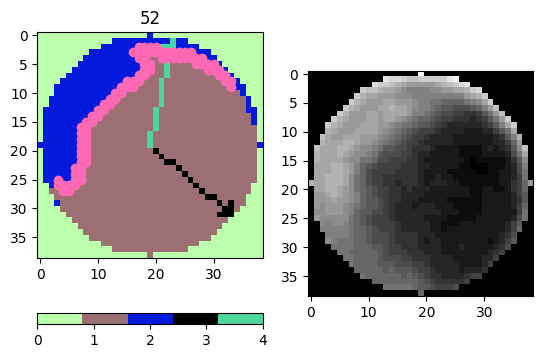

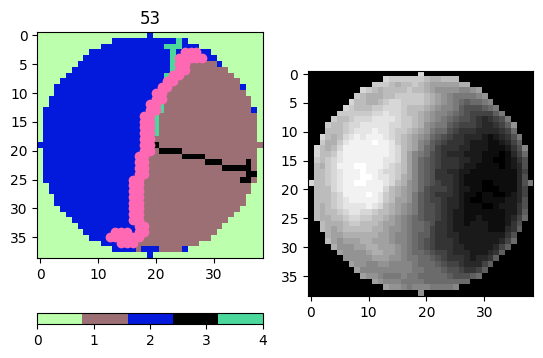

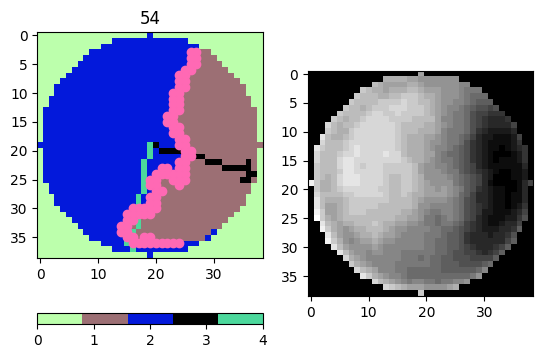

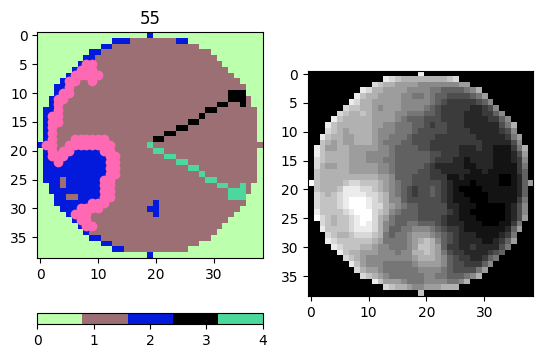

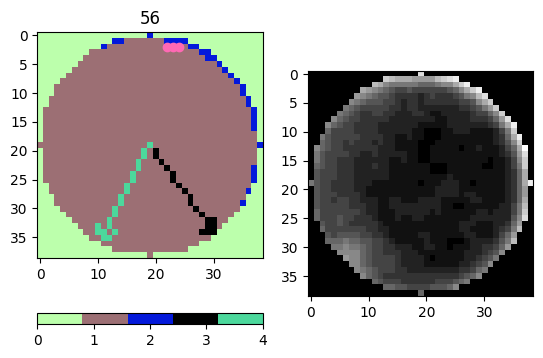

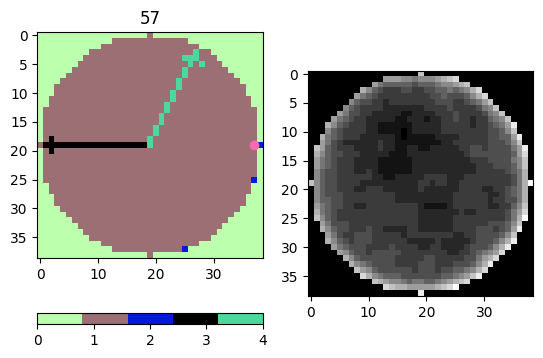

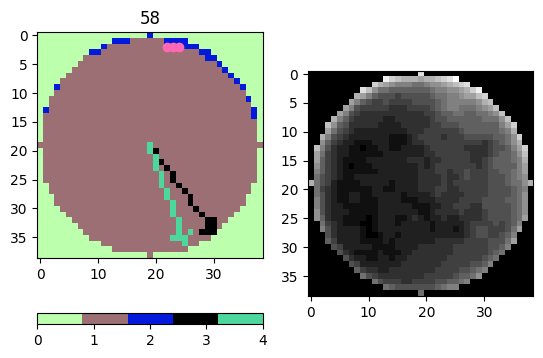

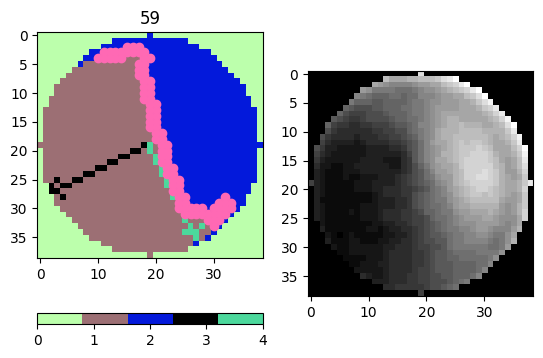

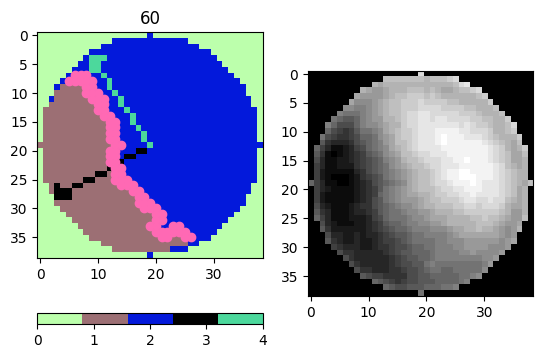

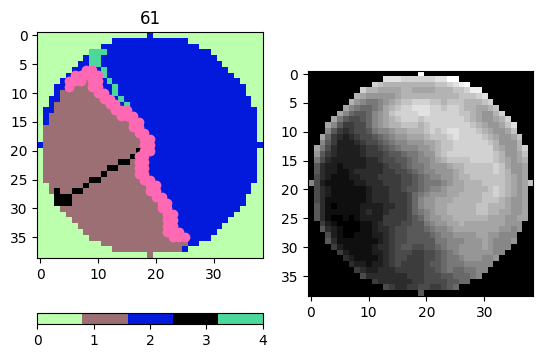

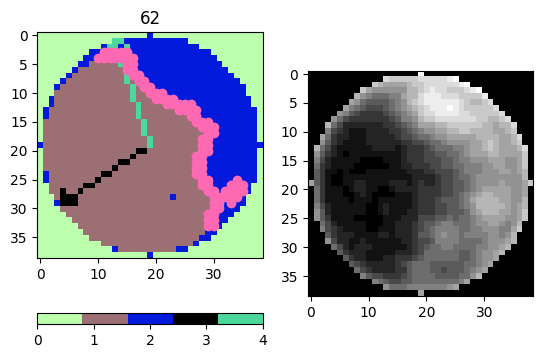

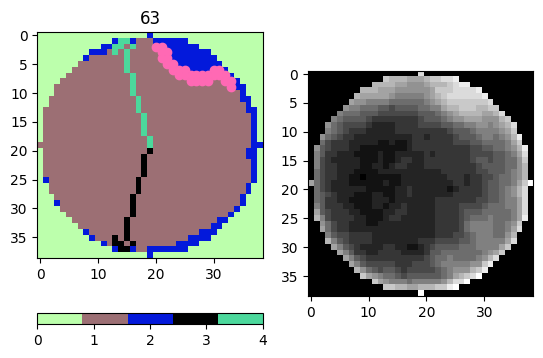

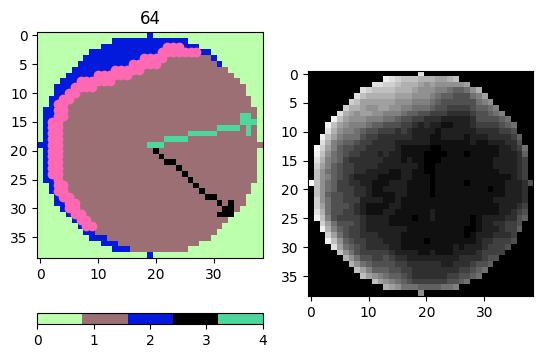

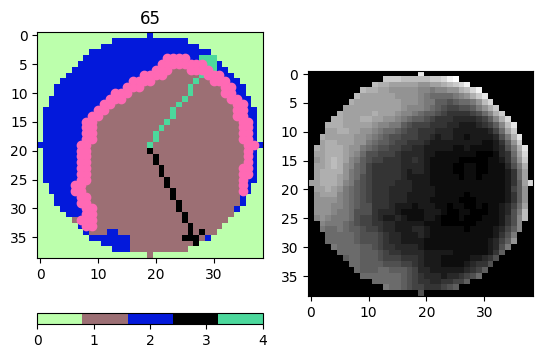

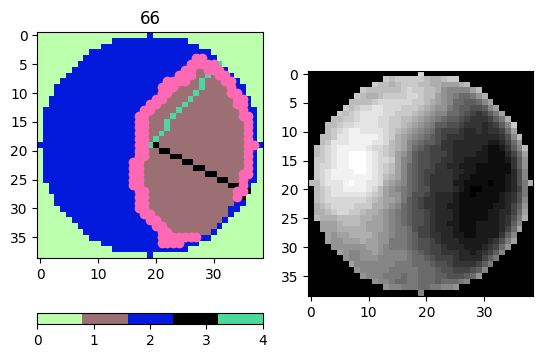

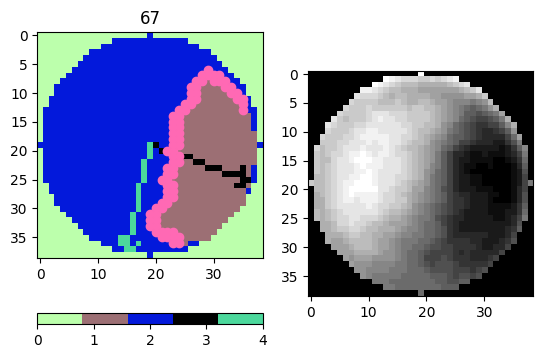

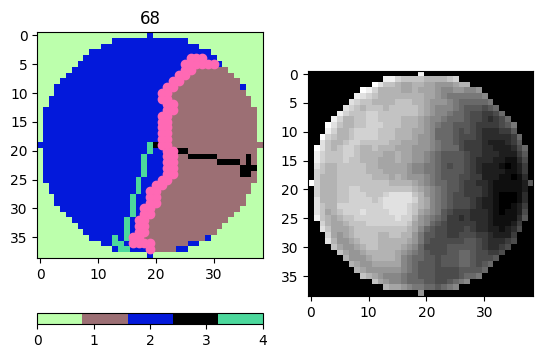

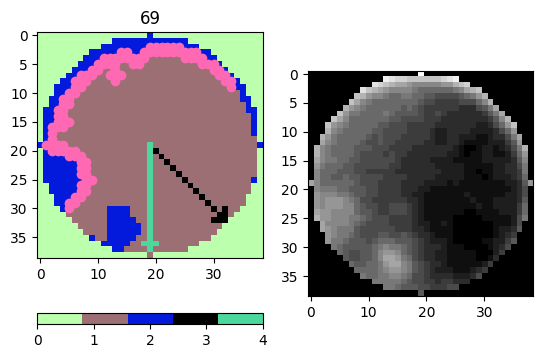

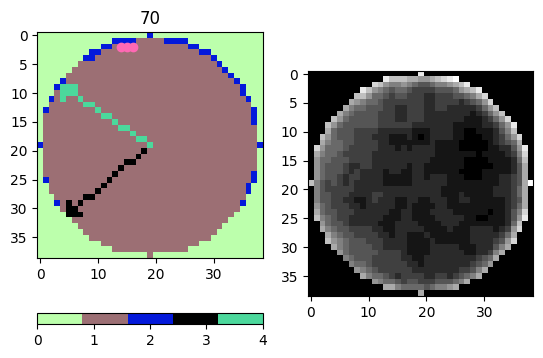

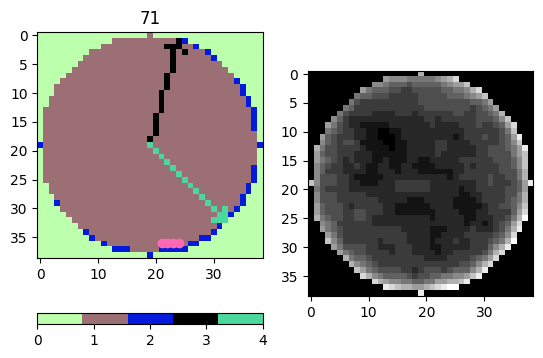

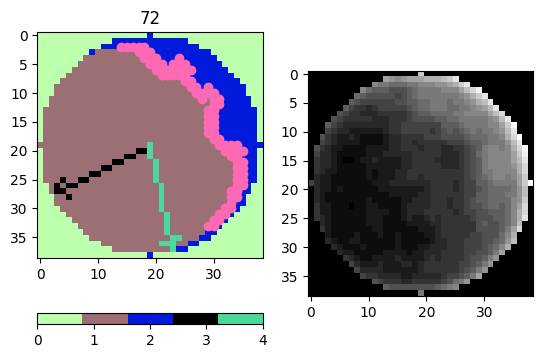

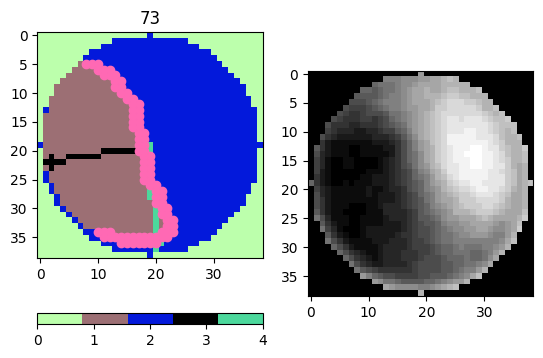

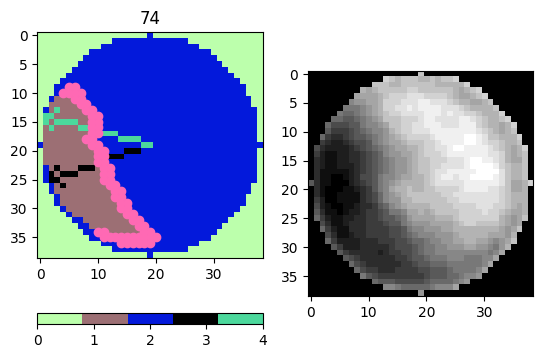

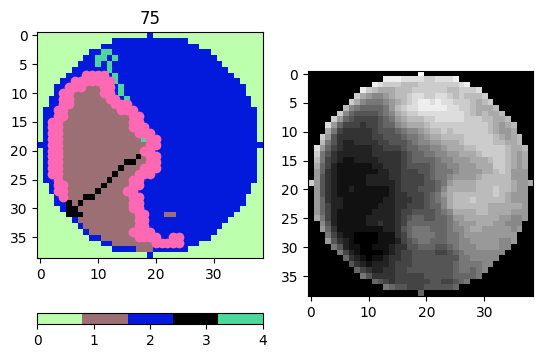

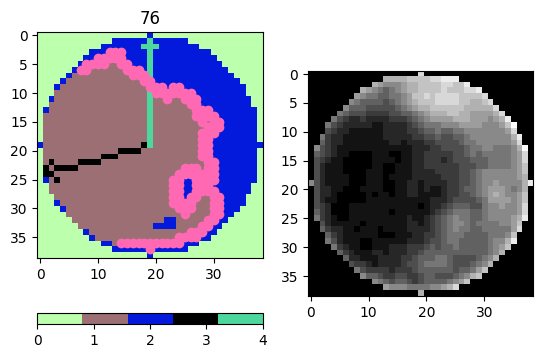

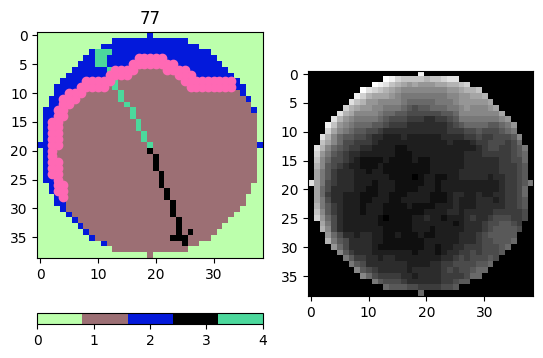

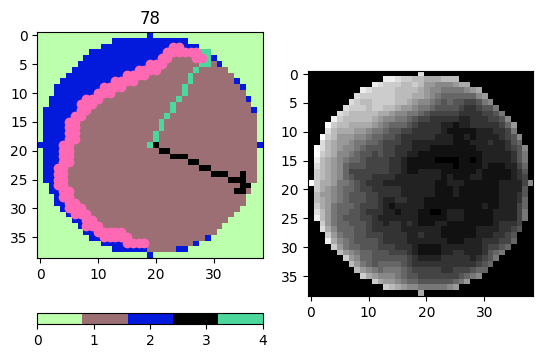

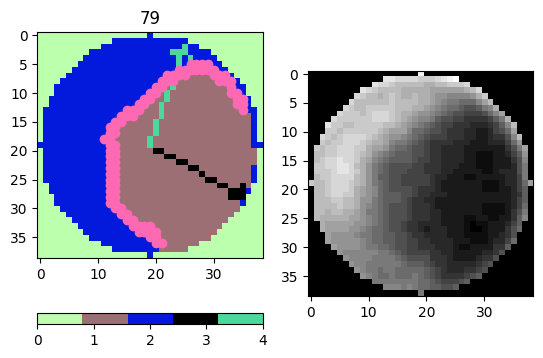

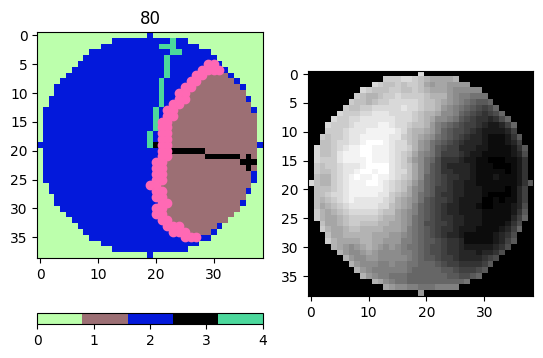

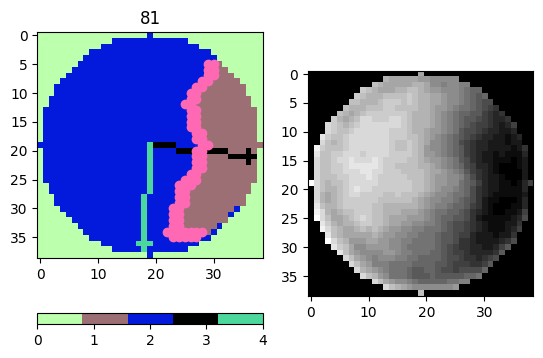

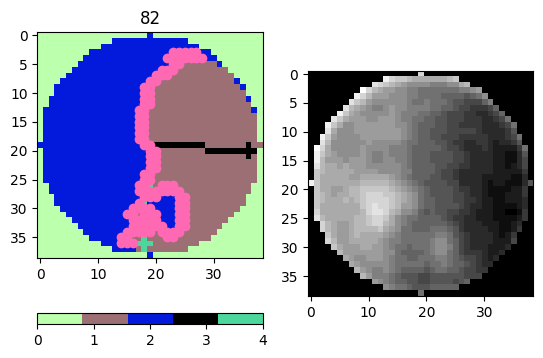

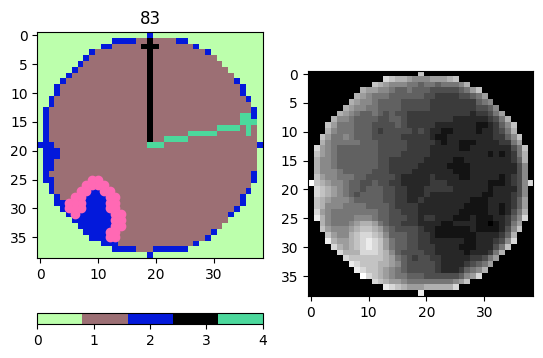

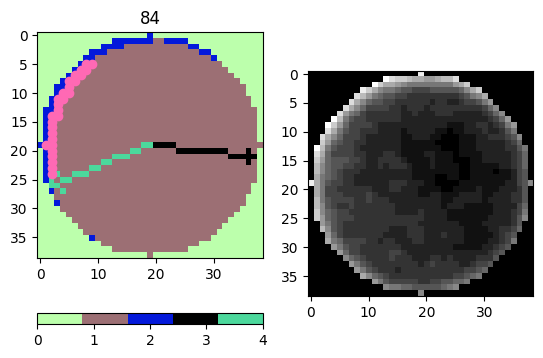

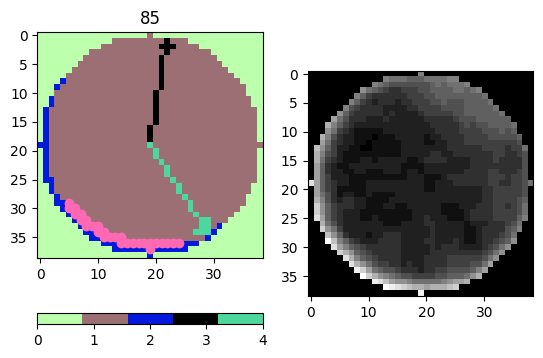

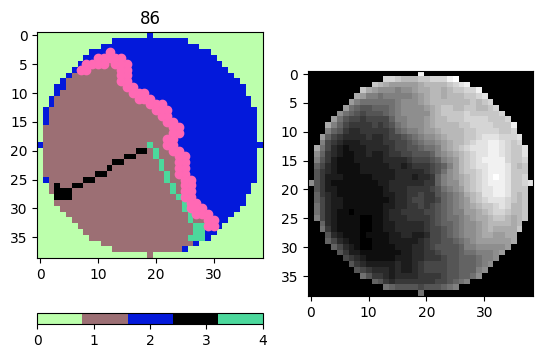

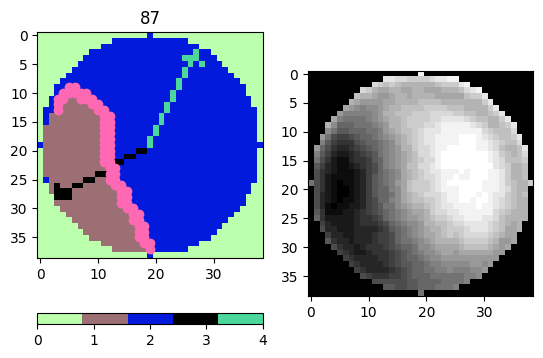

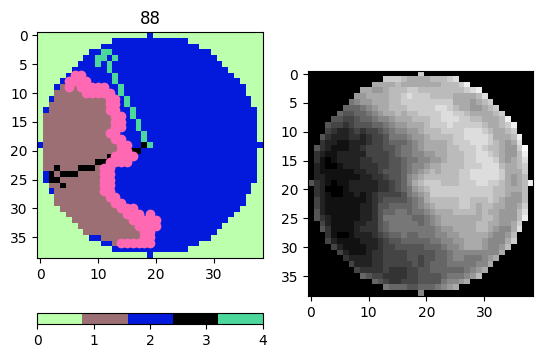

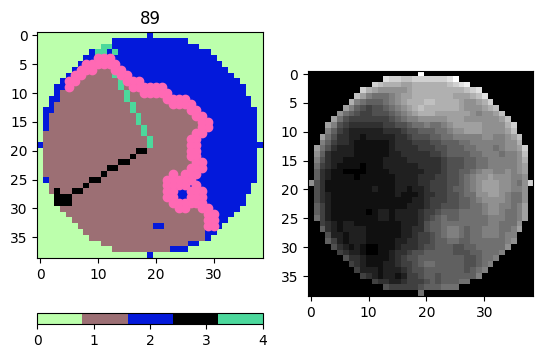

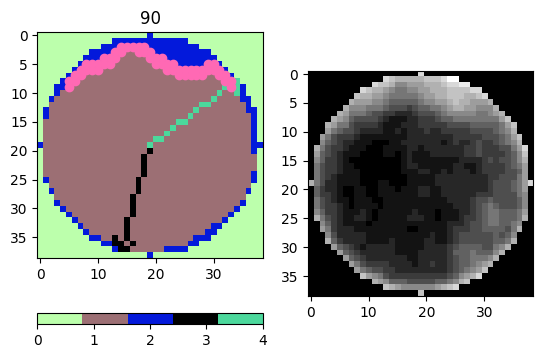

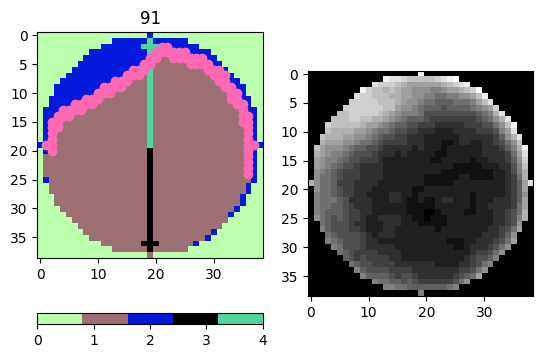

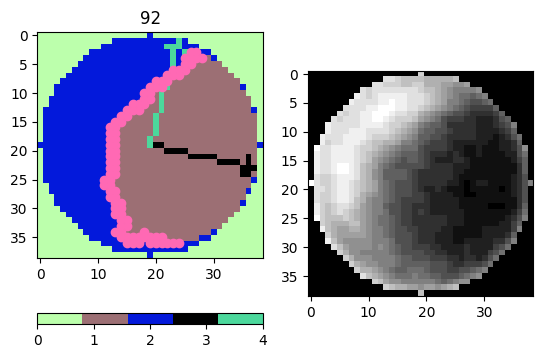

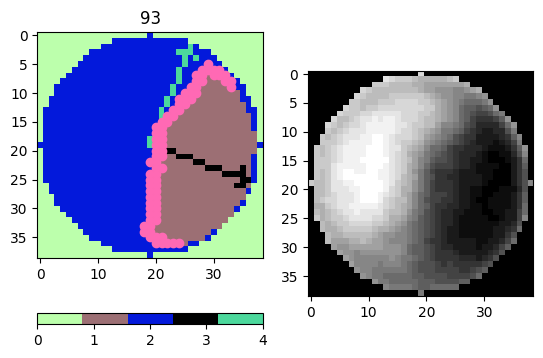

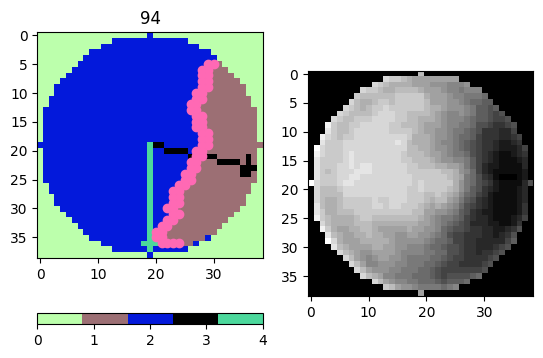

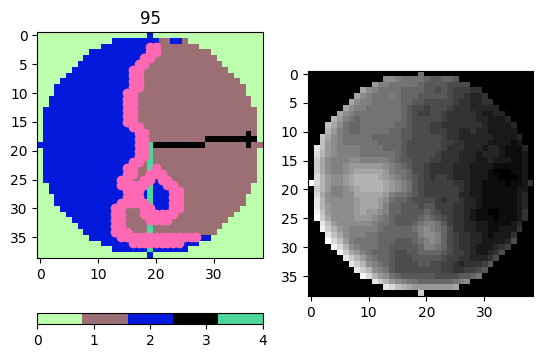

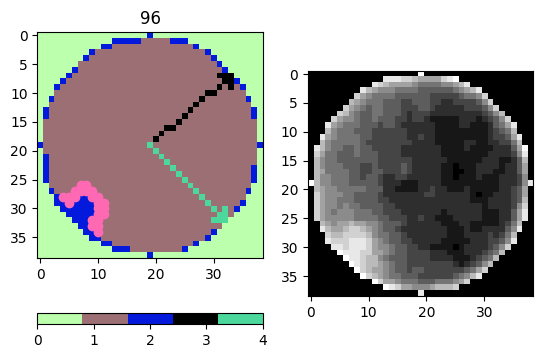

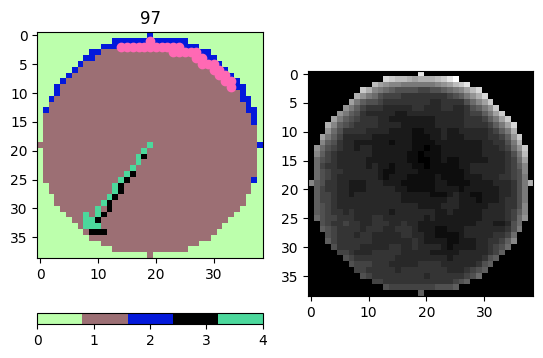

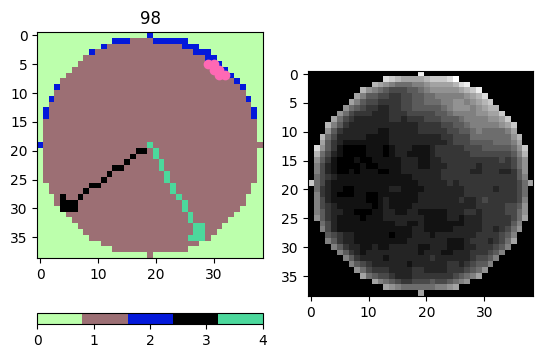

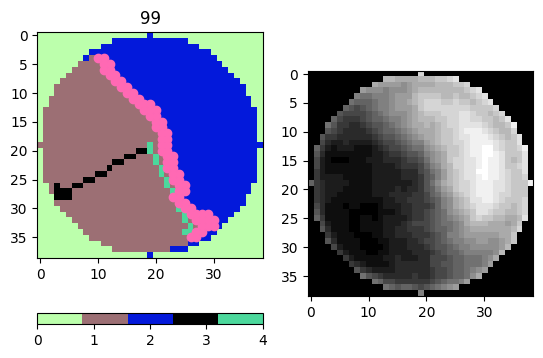

In [21]:
width=A[0].shape[0]
arrow_length = width//2
start_point = (width // 2, width // 2)


cmap = matplotlib.colors.ListedColormap(
                                        [[68,1,84],
                                         [100,145,140],
                                         [253,231,37],
                                         [0,255,255],
                                         [180,40,100]
                                         ])
for i in range(len(A)-1):
    v=np.copy(normal_vector_trajectory[:,i])
    v=v[:2]
    if np.linalg.norm(v)>1e-6:
        v/=np.linalg.norm(v)
    end_point = (start_point[0] + int(v[0] * arrow_length), start_point[1] + int(v[1] * arrow_length))
    im_obj=np.zeros((A[i].shape[0],A[i].shape[1],3),dtype=np.uint8)
    im_obj=cv.arrowedLine(im_obj, start_point, end_point, (0,0,255), 1)
    im_obj=cv.cvtColor(im_obj, cv.COLOR_BGR2GRAY)
    arrow_pixels_n=np.argwhere(im_obj==np.max(im_obj))

    v=np.copy(rotation_trajectories_as_rotvec[vizualised_obj_id][i,:])
    v=v[:2]
    if np.linalg.norm(v)>1e-6:
        v/=np.linalg.norm(v)
    end_point = (start_point[0] + int(v[0] * arrow_length), start_point[1] + int(v[1] * arrow_length))
    im_obj=np.zeros((A[i].shape[0],A[i].shape[1],3),dtype=np.uint8)
    im_obj=cv.arrowedLine(im_obj, start_point, end_point, (0,0,255), 1)
    im_obj=cv.cvtColor(im_obj, cv.COLOR_BGR2GRAY)
    arrow_pixels_r=np.argwhere(im_obj==np.max(im_obj))

    im_obj=np.copy(A[i])
    im_obj[arrow_pixels_n[:,0],arrow_pixels_n[:,1]]=3
    im_obj[arrow_pixels_r[:,0],arrow_pixels_r[:,1]]=4
    fig = plt.figure()
    ax1 = fig.add_subplot(121)    
    ax1.set_title(str(i))
    a=ax1.imshow(im_obj, cmap=cmap,vmin=0,vmax=4)
    ax1.scatter(C[i][:,0],C[i][:,1],color = 'hotpink')
    fig.colorbar(a,orientation='horizontal')
    ax=plt.subplot(122)
    obj_im_plot=particle_data_3d[i,:,:]
    vmin=np.min(obj_im_plot[M==1])
    vmax=np.max(obj_im_plot[M==1])
    ax.imshow(B[i],cmap="gray",vmin=vmin,vmax=vmax)
    plt.show()
